<a href="https://colab.research.google.com/github/KostaKat/SentryAI/blob/main/model_EfficientNet2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image
import random
import concurrent.futures
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import PIL.Image
import cv2
import random



## Smash and reconstruct

In [ ]:
import numpy as np
import cv2
import random
from PIL import Image

class Preprocessor:
    @staticmethod
    def img_to_patches(input_path: str) -> tuple:
        img = Image.open(input_path)
        if input_path[-4:] not in ['.jpg', '.jpeg', '.png']:  # Correcting the condition to include PNG
            img = img.convert('RGB')
        img = img.resize((256, 256))  # Ensuring the image is resized to 256x256
        patch_size = 32
        grayscale_patches = []
        color_patches = []
        for i in range(0, img.height, patch_size):
            for j in range(0, img.width, patch_size):
                box = (j, i, j + patch_size, i + patch_size)
                patch = np.array(img.crop(box))
                grayscale_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
                grayscale_patches.append(grayscale_patch.astype(np.int32))
                color_patches.append(patch)
        return grayscale_patches, color_patches

    @staticmethod
    def get_l1(v):
        return np.sum(np.abs(v[:, :-1] - v[:, 1:]))

    @staticmethod
    def get_l2(v):
        return np.sum(np.abs(v[:-1, :] - v[1:, :]))

    @staticmethod
    def get_l3l4(v):
        l3 = np.sum(np.abs(v[:-1, :-1] - v[1:, 1:]))
        l4 = np.sum(np.abs(v[1:, :-1] - v[:-1, 1:]))
        return l3 + l4

    @staticmethod
    def get_pixel_var_degree_for_patch(patch):
        l1 = Preprocessor.get_l1(patch)
        l2 = Preprocessor.get_l2(patch)
        l3l4 = Preprocessor.get_l3l4(patch)
        return l1 + l2 + l3l4

    @staticmethod
    def extract_rich_and_poor_textures(variance_values, patches):
        threshold = np.mean(variance_values)
        rich_patches = [patch for i, patch in enumerate(patches) if variance_values[i] >= threshold]
        poor_patches = [patch for i, patch in enumerate(patches) if variance_values[i] < threshold]
        return rich_patches, poor_patches

    @staticmethod
    def get_complete_image(patches, colored=True):
        random.shuffle(patches)  # Random shuffling of patches
        while len(patches) < 64:
            patches += patches[:64 - len(patches)]
        grid = np.array(patches).reshape((8, 8, 32, 32, -1))
        rows = [np.concatenate(row_patches, axis=1) for row_patches in grid]
        complete_image = np.concatenate(rows, axis=0)
        return complete_image

    @staticmethod
    def smash_n_reconstruct(input_path, colored=True):
        grayscale_patches, color_patches = Preprocessor.img_to_patches(input_path)
        pixel_var_degree = [Preprocessor.get_pixel_var_degree_for_patch(patch) for patch in grayscale_patches]

        if colored:
            rich_patches, poor_patches = Preprocessor.extract_rich_and_poor_textures(pixel_var_degree, color_patches)
        else:
            rich_patches, poor_patches = Preprocessor.extract_rich_and_poor_textures(pixel_var_degree, grayscale_patches)

        rich_texture = Preprocessor.get_complete_image(rich_patches, colored)
        poor_texture = Preprocessor.get_complete_image(poor_patches, colored)

        return rich_texture, poor_texture


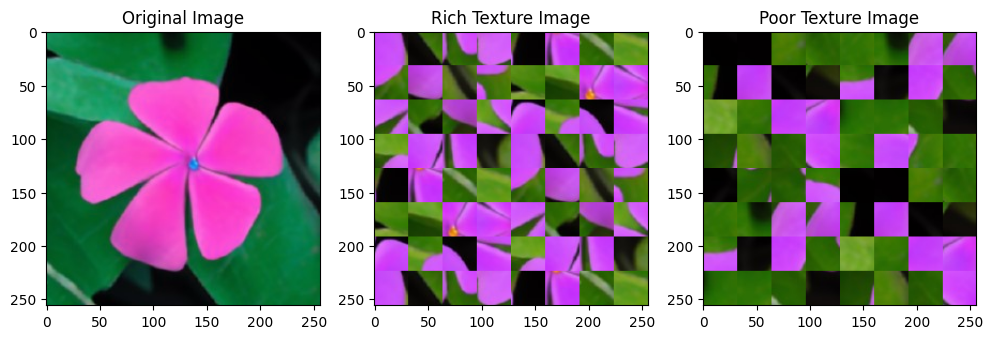

In [ ]:
img_path = "/img1.jpeg"

rich_texture_img, poor_texture_img = Preprocessor().smash_n_reconstruct(img_path)
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 3, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.show()

In [ ]:
def apply_high_pass_filters(image):
    kernels = [
        np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], np.float32),  # Example Laplacian
        np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], np.float32)  # High-pass
    ]
    angles = [0, 90, 180, 270]  # Degrees to rotate kernels

    filtered_images = []
    for kernel in kernels:
        for angle in angles:
            rotated_kernel = rotate(kernel, angle, reshape=False)
            filtered_image = cv2.filter2D(image, -1, rotated_kernel)
            filtered_images.append(filtered_image)

    return filtered_images

In [ ]:
import cv2
import numpy as np
from scipy.ndimage import rotate

high_pass_image = apply_high_pass_filters(rich_texture_img)

TypeError: Invalid shape (8, 256, 256, 3) for image data

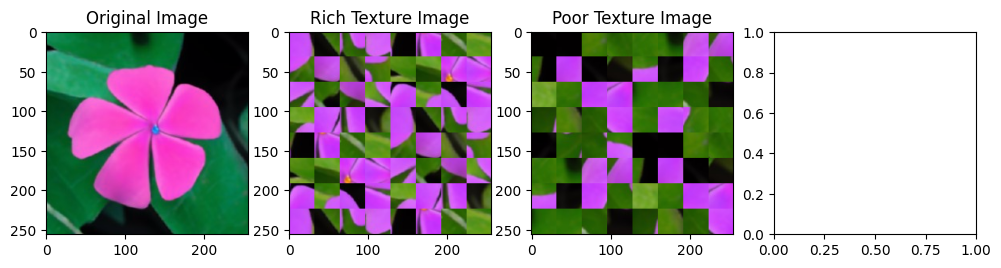

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 4, 2)
plt.imshow(rich_texture_img, cmap='gray')
plt.title('Rich Texture Image')
plt.subplot(1, 4, 3)
plt.imshow(poor_texture_img, cmap='gray')
plt.title('Poor Texture Image')
plt.subplot(1, 4, 4)
plt.imshow(high_pass_image, cmap='gray')
plt.title('High pass rich')
plt.show()

In [ ]:
import cv2
import numpy as np
from scipy.ndimage import rotate

def apply_high_pass_filters(image):
    kernels = [
        np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], np.float32),  # Example Laplacian
        np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], np.float32)  # High-pass
    ]
    angles = [0, 90, 180, 270]  # Degrees to rotate kernels

    filtered_images = []
    for kernel in kernels:
        for angle in angles:
            rotated_kernel = rotate(kernel, angle, reshape=False)
            filtered_image = cv2.filter2D(image, -1, rotated_kernel)
            filtered_images.append(filtered_image)

    return filtered_images

def main(input_path):
    # Use the smash and reconstruct to process the image first
    rich_texture, poor_texture = Preprocessor.smash_n_reconstruct(input_path, colored=False)

    # Convert rich_texture and poor_texture to uint8 for filtering
    rich_texture = np.uint8(rich_texture)
    poor_texture = np.uint8(poor_texture)

    # Apply high-pass filters
    filtered_rich_images = apply_high_pass_filters(rich_texture)
    filtered_poor_images = apply_high_pass_filters(poor_texture)

    # Optionally, here you could add steps to convert these filtered images to frequency domain (using DCT)
    # and train a classifier as illustrated previously.

    return filtered_rich_images, filtered_poor_images

# Example usage
filtered_rich_images, filtered_poor_images = main('/img1.jpeg')


8


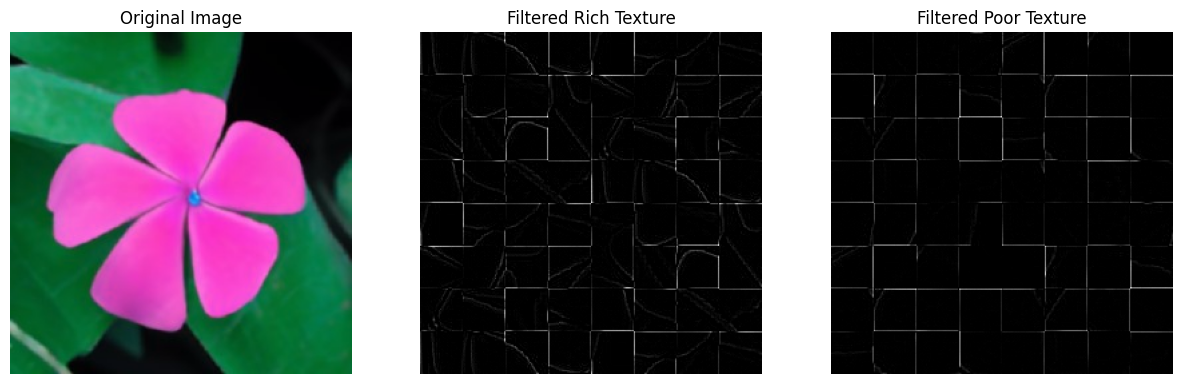

In [ ]:
import matplotlib.pyplot as plt

def plot_images(images, titles):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Load original image for comparison
original_image = cv2.imread('/img1.jpeg', cv2.IMREAD_COLOR)
original_image = cv2.resize(original_image, (256, 256))

print(len(filtered_rich_images))

# Plotting
plot_images(
    [original_image, filtered_rich_images[0], filtered_poor_images[0]],
    ['Original Image', 'Filtered Rich Texture', 'Filtered Poor Texture']
)


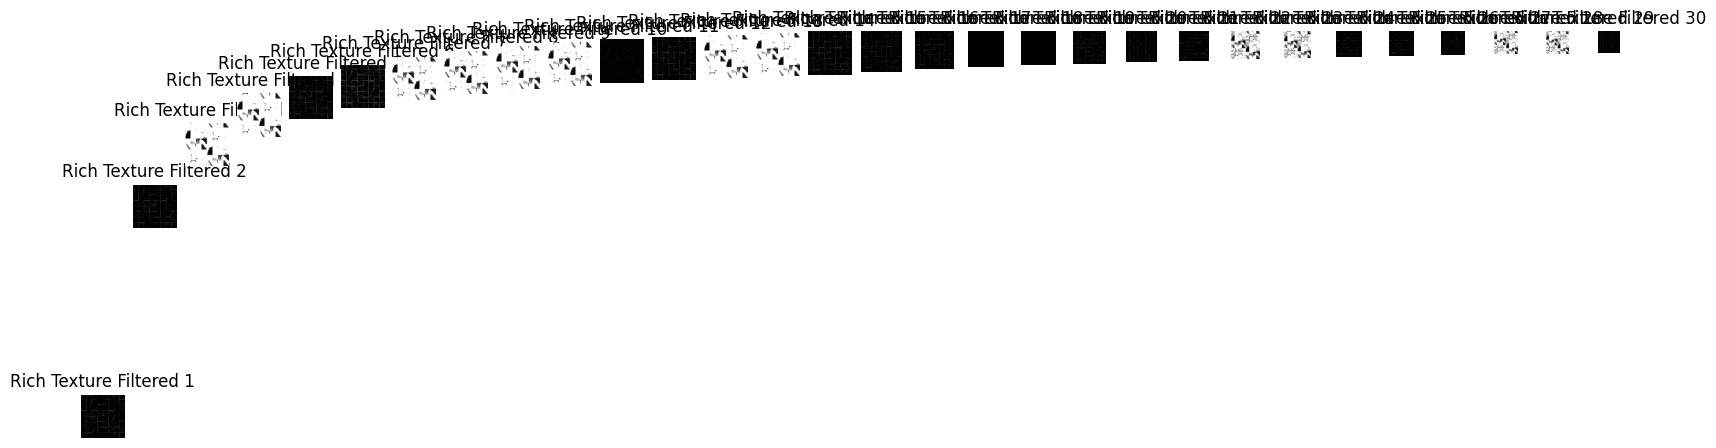

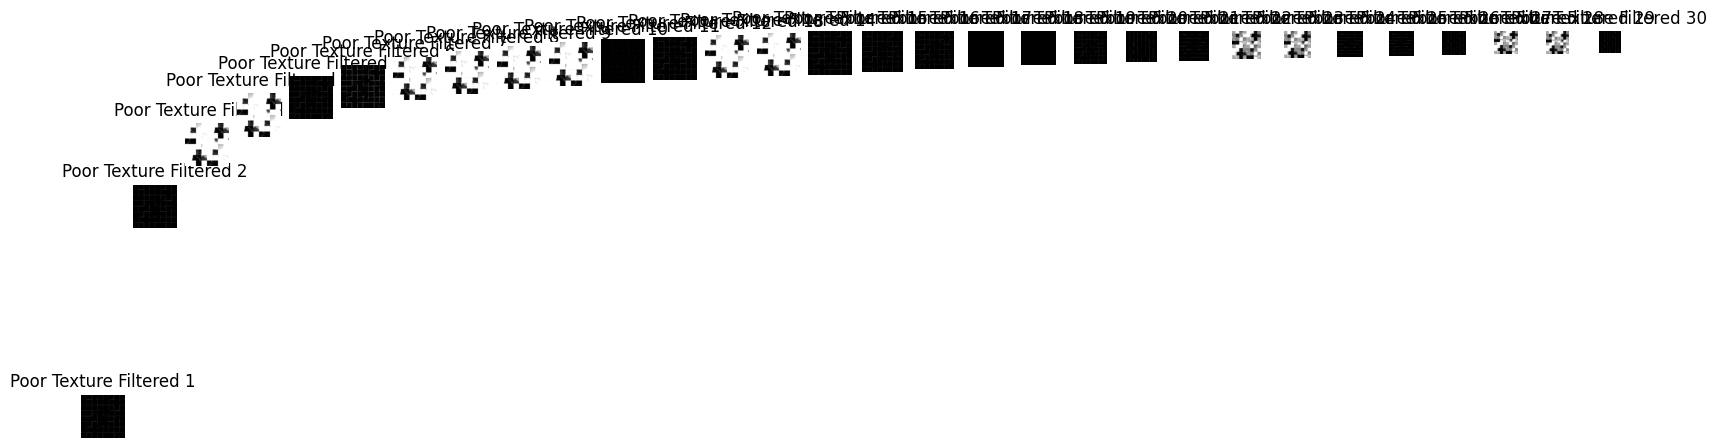

In [ ]:
def plot_filtered_images(filtered_images, title):
    plt.figure(figsize=(20, 10))
    columns = len(filtered_images)
    idx = 0
    for i, image in enumerate(filtered_images):
        plt.subplot(1 + idx, columns, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'{title} Filtered {i+1}')
        plt.axis('off')
        idx += 1
    plt.show()

plot_filtered_images(filtered_rich_images, "Rich Texture")
plot_filtered_images(filtered_poor_images, "Poor Texture")

In [ ]:

def apply_high_pass_filters(image):
    kernels = [
        np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),  # Example Laplacian
        np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32),  # High-pass
        np.array([[1, -2, 1], [-2, 4, -2], [1, -2, 1]], dtype=np.float32),  # Edge detection
        np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32),  # Inverse Laplace
        np.array([[0, 0, 0], [-1, 2, -1], [0, 0, 0]], dtype=np.float32),  # Horizontal line detect
        np.array([[0, -1, 0], [0, 2, 0], [0, -1, 0]], dtype=np.float32)   # Vertical line detect
    ]
    angles = [0, 72, 144, 216, 288]  # Five angles for each of the six kernels

    filtered_images = []
    for kernel in kernels:
        for angle in angles:
            rotated_kernel = rotate(kernel, angle, reshape=False)
            rotated_kernel = np.round(rotated_kernel).astype(np.float32)  # Ensure type consistency for filtering
            filtered_image = cv2.filter2D(image, -1, rotated_kernel)
            filtered_images.append(filtered_image)

    return filtered_images

def main(input_path):
    # Use the smash and reconstruct to process the image first
    rich_texture, poor_texture = Preprocessor.smash_n_reconstruct(input_path, colored=False)

    # Convert rich_texture and poor_texture to uint8 for filtering
    rich_texture = np.uint8(rich_texture)
    poor_texture = np.uint8(poor_texture)

    # Apply high-pass filters
    filtered_rich_images = apply_high_pass_filters(rich_texture)
    filtered_poor_images = apply_high_pass_filters(poor_texture)

    return filtered_rich_images, filtered_poor_images

In [ ]:
filtered_rich_images, filtered_poor_images = main('/img1.jpeg')

In [ ]:
import numpy as np

kernels = np.array([np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, -1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, -1, 0, 0],
    [0, 0, 3, 0, 0],
    [0, 0, -3, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, -2, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, 0, 0, 0],
    [0, -1, 2, -1, 0],
    [0, 2, -4, 2, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [-1, 2, -2, 2, -1],
    [2, -6, 8, -6, 2],
    [-2, 8, -12, 8, -2],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, 0, 0, 0],
    [0, -1, 2, -1, 0],
    [0, 2, -4, 2, 0],
    [0, -1, 2, -1, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [-1, 2, -2, 2, -1],
    [2, -6, 8, -6, 2],
    [-2, 8, -12, 8, -2],
    [2, -6, 8, -6, 2],
    [-1, 2, -2, 2, -1],
])])

angles = [
    [45, 90, 135, 180, 225, 270, 315, 0],
    [0, 45, 90, 135, 180, 225, 270, 315],
    [90, 180, 45, 135],
    [90, 180, 270, 0],
    [90, 180, 270, 0],
    [0],
    [0]
]

In [ ]:
def apply_high_pass_filter(image):
    filtered_images = []
    rotated_kernels = []

    for idx, kernel in enumerate(kernels):
        for angle in angles[idx]:
            rotated_kernel = rotate(kernel, angle, reshape=False)
            rotated_kernel = np.round(rotated_kernel)
            rotated_kernels.append(rotated_kernel)

    for rotated_kernel in rotated_kernels:
        filtered_image = cv2.filter2D(image, -1, rotated_kernel)
        filtered_images.append(filtered_image)

    # Stack images and compute the average
    filtered_images_np = np.stack(filtered_images, axis=0)
    average_filtered_image = np.mean(filtered_images_np, axis=0)

    # Convert the averaged image to a tensor and fix dimensions
    average_filtered_tensor = torch.tensor(
        average_filtered_image.transpose(2, 0, 1)).float()

    # show image with high pass filter
    plt.imshow(average_filtered_image)
    return average_filtered_tensor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def main(input_path):
    # Use the smash and reconstruct to process the image first
    rich_texture, poor_texture = Preprocessor.smash_n_reconstruct(input_path, colored=False)

    # Convert rich_texture and poor_texture to uint8 for filtering
    rich_texture = np.uint8(rich_texture)
    poor_texture = np.uint8(poor_texture)

    # Apply high-pass filters
    filtered_rich_images = apply_high_pass_filter(rich_texture)
    filtered_poor_images = apply_high_pass_filter(poor_texture)

    return filtered_rich_images, filtered_poor_images

In [ ]:
filtered_rich_images, filtered_poor_images = main('/img1.jpeg')

ValueError: axes don't match array

### New


In [ ]:
import numpy as np

kernels = np.array([np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, -1, 0, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, -1, 0, 0],
    [0, 0, 3, 0, 0],
    [0, 0, -3, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, -2, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, 0, 0, 0],
    [0, -1, 2, -1, 0],
    [0, 2, -4, 2, 0],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [-1, 2, -2, 2, -1],
    [2, -6, 8, -6, 2],
    [-2, 8, -12, 8, -2],
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [0, 0, 0, 0, 0],
    [0, -1, 2, -1, 0],
    [0, 2, -4, 2, 0],
    [0, -1, 2, -1, 0],
    [0, 0, 0, 0, 0]
]), np.array([
    [-1, 2, -2, 2, -1],
    [2, -6, 8, -6, 2],
    [-2, 8, -12, 8, -2],
    [2, -6, 8, -6, 2],
    [-1, 2, -2, 2, -1],
])])

angles = [
    [45, 90, 135, 180, 225, 270, 315, 0],
    [0, 45, 90, 135, 180, 225, 270, 315],
    [90, 180, 45, 135],
    [90, 180, 270, 0],
    [90, 180, 270, 0],
    [0],
    [0]
]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
from PIL import Image, ImageFilter
import io
import matplotlib.pyplot as plt
import random
from skimage import data
from scipy.ndimage import rotate


def img_to_patches(img) -> tuple:

    if (img.size != (256, 256)):
        img = img.resize((256, 256))
    patch_size = 32
    grayscale_patches = []
    color_patches = []
    for i in range(0, img.height, patch_size):
        for j in range(0, img.width, patch_size):
            box = (j, i, j + patch_size, i + patch_size)
            patch = np.asarray(img.crop(box))
            grayscale_patch = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            grayscale_patches.append(grayscale_patch.astype(np.int32))
            color_patches.append(patch)
    return grayscale_patches, color_patches


def get_l1(v):
    return np.sum(np.abs(v[:, :-1] - v[:, 1:]))


def get_l2(v):
    return np.sum(np.abs(v[:-1, :] - v[1:, :]))


def get_l3l4(v):
    l3 = np.sum(np.abs(v[:-1, :-1] - v[1:, 1:]))
    l4 = np.sum(np.abs(v[1:, :-1] - v[:-1, 1:]))
    return l3 + l4


def get_pixel_var_degree_for_patch(patch):
    l1 = get_l1(patch)
    l2 = get_l2(patch)
    l3l4 = get_l3l4(patch)
    return l1 + l2 + l3l4


def extract_rich_and_poor_textures(variance_values, patches):
    threshold = np.mean(variance_values)
    rich_patches = [patch for i, patch in enumerate(
        patches) if variance_values[i] >= threshold]
    poor_patches = [patch for i, patch in enumerate(
        patches) if variance_values[i] < threshold]
    return rich_patches, poor_patches


def get_complete_image(patches, coloured=True):
    random.shuffle(patches)
    while len(patches) < 64:
        patches += patches[:64 - len(patches)]
    grid = np.array(patches).reshape((8, 8, 32, 32, 3)) if coloured else np.array(
        patches).reshape((8, 8, 32, 32))
    rows = [np.concatenate(row_patches, axis=1) for row_patches in grid]
    complete_image = np.concatenate(rows, axis=0)
    return complete_image


def smash_n_reconstruct(input_path, coloured=True):
    grayscale_patches, color_patches = img_to_patches(input_path)
    pixel_var_degree = [get_pixel_var_degree_for_patch(
        patch) for patch in grayscale_patches]

    if coloured:
        rich_patches, poor_patches = extract_rich_and_poor_textures(
            pixel_var_degree, color_patches)
    else:
        rich_patches, poor_patches = extract_rich_and_poor_textures(
            pixel_var_degree, grayscale_patches)

    rich_texture = get_complete_image(rich_patches, coloured)
    poor_texture = get_complete_image(poor_patches, coloured)

    return rich_texture, poor_texture


# Define the image processing functions
def jpeg_compression(img, quality_range=(70, 100)):
    if random.random() < 0.1:  # 10% probability
        quality = random.randint(*quality_range)
        img_bytes = io.BytesIO()
        img.save(img_bytes, format='JPEG', quality=quality)
        img = Image.open(img_bytes)
    return img


def gaussian_blur(img, sigma_range=(0, 1)):
    if random.random() < 0.1:  # 10% probability
        sigma = random.uniform(*sigma_range)
        img = img.filter(ImageFilter.GaussianBlur(sigma))
    return img


def downsampling(img, scale_range=(0.25, 0.5)):
    if random.random() < 0.1:  # 10% probability
        scale = random.uniform(*scale_range)
        smaller_img = img.resize(
            (int(img.width * scale), int(img.height * scale)), Image.BICUBIC)
        img = smaller_img.resize((img.width, img.height), Image.BICUBIC)
    return img


def apply_high_pass_filter(image):
    filtered_images = []
    rotated_kernels = []

    for idx, kernel in enumerate(kernels):
        for angle in angles[idx]:
            rotated_kernel = rotate(kernel, angle, reshape=False)
            rotated_kernel = np.round(rotated_kernel)
            rotated_kernels.append(rotated_kernel)

    for rotated_kernel in rotated_kernels:
        filtered_image = cv2.filter2D(image, -1, rotated_kernel)
        filtered_images.append(filtered_image)

    # Stack images and compute the average
    filtered_images_np = np.stack(filtered_images, axis=0)
    average_filtered_image = np.mean(filtered_images_np, axis=0)

    # Convert the averaged image to a tensor and fix dimensions
    average_filtered_tensor = torch.tensor(
        average_filtered_image.transpose(2, 0, 1)).float()

    # show image with high pass filter
    plt.imshow(average_filtered_image)
    return average_filtered_tensor


# Define the image processing functions
def jpeg_compression(img, quality_range=(70, 100)):
    if random.random() < 0.1:  # 10% probability
        quality = random.randint(*quality_range)
        img_bytes = io.BytesIO()
        img.save(img_bytes, format='JPEG', quality=quality)
        img = Image.open(img_bytes)
    return img


def gaussian_blur(img, sigma_range=(0, 1)):
    if random.random() < 0.1:  # 10% probability
        sigma = random.uniform(*sigma_range)
        img = img.filter(ImageFilter.GaussianBlur(sigma))
    return img


def downsampling(img, scale_range=(0.25, 0.5)):
    if random.random() < 0.1:  # 10% probability
        scale = random.uniform(*scale_range)
        smaller_img = img.resize(
            (int(img.width * scale), int(img.height * scale)), Image.BICUBIC)
        img = smaller_img.resize((img.width, img.height), Image.BICUBIC)
    return img

In [ ]:
from scipy.fftpack import dct

def apply_dct(image):
    return dct(dct(image.T, norm='ortho').T, norm='ortho')


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class FreDectDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))  # Resize images to fixed size

        high_pass_image = apply_high_pass_filter(image)
        dct_image = apply_dct(high_pass_image)

        if self.transform:
            dct_image = self.transform(dct_image)

        return dct_image
